### env: base

In [3]:

import random
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import json
import os

from sklearn.metrics import classification_report, roc_auc_score
from scipy import interpolate
from sklearn.metrics import roc_curve, auc
from cycler import cycler
# from awkward import ak

import uproot ## means uproot4
import sklearn.metrics as m

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [4]:

CustNanoData = {
    # 'Test' : '/data/pubfs/zhaoyz/SlimmedTree/V5/2018/Signal/SlimmedTree_GluGlu.root',
    'SingleMuon'   : "/data/pubfs/zhaoyz/Tree/V8/2018/Merged/SingleMuon/Tree_SingleMuon.root",
    # 'JetHT'   : "/data/pubfs/zhaoyz/Tree/V8/2018/Merged/Data/Tree_Data.root",            
    'QCD'     : "/data/pubfs/zhaoyz/Tree/V8/2018/Merged/MC/Tree_QCD.root",            
    # 'Signal'  : "/data/pubfs/zhaoyz/Tree/V8/2018/Merged/Signal/Tree_Total.root",
    # 'GluGlu'  : "/data/pubfs/zhaoyz/Tree/V8/2018/Merged/Signal/Tree_GluGlu.root",            
    # 'VH'      : "/data/pubfs/zhaoyz/Tree/V8/2018/Merged/Signal/Tree_VH.root",            
    # 'VBF'     : "/data/pubfs/zhaoyz/Tree/V8/2018/Merged/Signal/Tree_VBF.root",            
    # 'ttH'     : "/data/pubfs/zhaoyz/Tree/V8/2018/Merged/Signal/Tree_ttH.root",            
            
}
events = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    events[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" }) ## lazy means lazy computation style
    # for var in ak_arrays.fields:
    #     if "HLT" in var or "FatJet" in var:
    #         events[year][var] = ak_arrays[var]

In [5]:
MAIN_DIR = ".."

plot_dir = f"{MAIN_DIR}/plots/trigger/8Mar24"
_ = os.system(f"mkdir -p {plot_dir}")

In [3]:
# some test
# print(events["Test"]["weight"][:10])

[0.00922, 0.0108, 0.0102, 0.0118, 0.0111, 0.0111, 0.0113, 0.0106, 0.012, 0.0113]


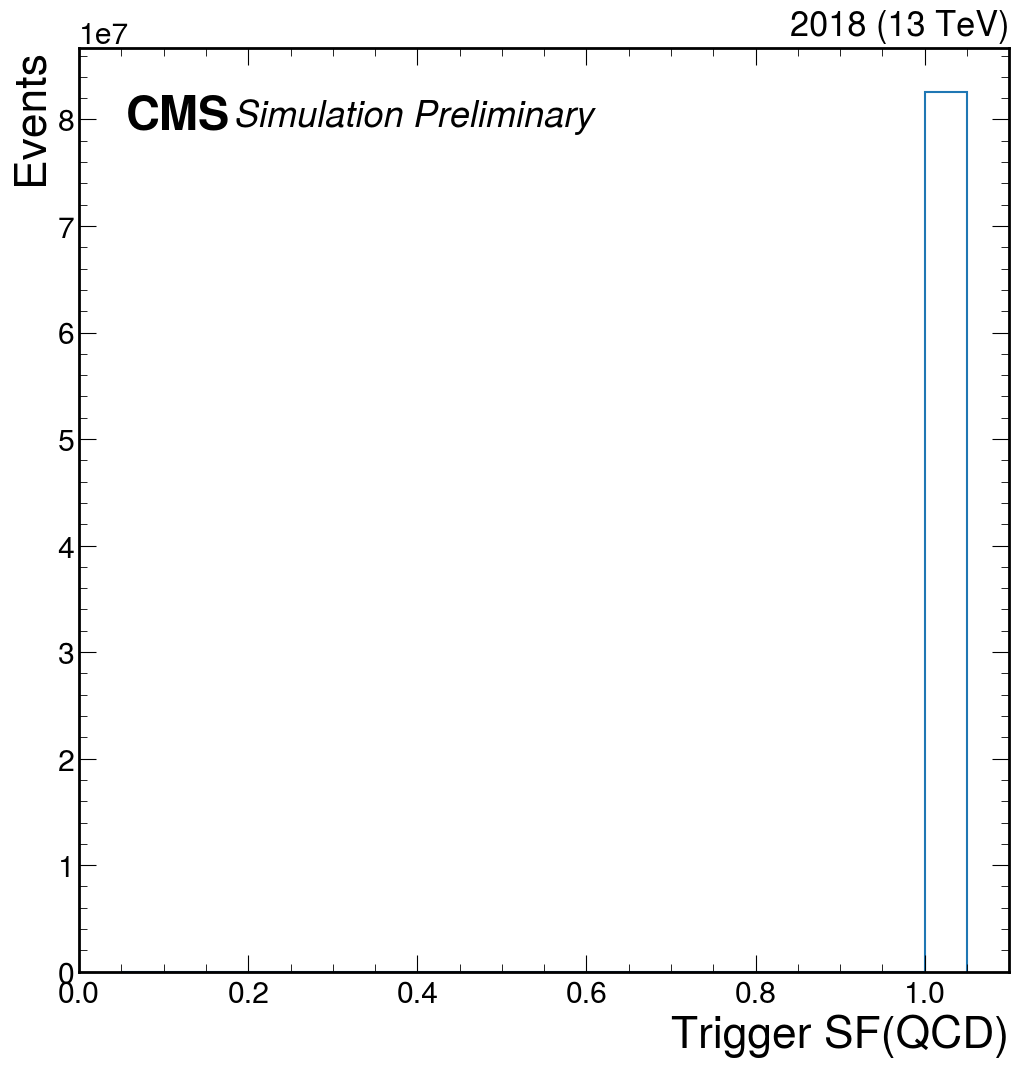

In [6]:
SFbins, SFmin, SFmax = 20, 0.05, 1.05
plt.figure(figsize=(12,12))
ax=plt.gca()
hep.cms.label(data= False, label = "Preliminary", year="2018", ax=ax, fontname='sans-serif', loc = 1)
hist1DSF = bh.Histogram(bh.axis.Regular(SFbins, SFmin, SFmax),storage=bh.storage.Weight())
hist1DSF.fill(events["QCD"]["TriggerSF"],weight = events["QCD"]["weight"])
h, err = hist1DSF.view().value, np.sqrt(hist1DSF.view().variance)
hep.histplot(h, bins=hist1DSF.axes[0].edges, yerr=err, histtype='step', stack=False)
plt.xlabel(r"Trigger SF(QCD)", fontsize=32, ha='right', x=1)
plt.ylabel(r"Events", fontsize=32, ha='right', y=1)
plt.savefig(f"{plot_dir}/2018QCDTriggerSF.pdf", bbox_inches='tight')
plt.show()

In [7]:
#Plot 2D trigger efficiency SFs unc.
def SF2DUnc_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2018", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet500"] == True)  | (eventsMC["HLT_PFHT1050"] == True)  | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True)  | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_PFHT1050"] == True)  | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True)  | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D


    
    #Start to calculate the uncentainty.
    Invera = 1./hist2DData_Cut.view().value
    Inverc = 1./hist2DData.view().value
    Inverb = 1./hist2DMC.view().value
    Inverd = 1./hist2DMC_Cut.view().value
    Sa = hist2DData_Cut.view().variance
    Sc = hist2DData.view().variance
    Sb = hist2DMC.view().variance
    Sd = hist2DMC_Cut.view().variance
                
    RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (Inverc**2) * Sc + (Inverd**2) * Sd )
    Unc = Effi2DSF * RelaUnc
    
    #define mesh
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Unc.T , vmin = 0, vmax = 1 )
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Unc
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2018_unc.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor uncertainty', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Higgs candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Higgs candidate $p_{T}$", fontsize=32, ha='right', y=1)
    plt.savefig(f"{plot_dir}/2018Unc" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/tmp/ipykernel_140271/3039236379.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_140271/3039236379.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value
/tmp/ipykernel_140271/3039236379.py:44: RuntimeWarning: divide by zero encountered in divide
  Effi2DSF = EffiData2D/EffiMC2D
/tmp/ipykernel_140271/3039236379.py:49: RuntimeWarning: divide by zero encountered in divide
  Invera = 1./hist2DData_Cut.view().value
/tmp/ipykernel_140271/3039236379.py:50: RuntimeWarning: divide by zero encountered in divide
  Inverc = 1./hist2DData.view().value
/tmp/ipykernel_140271/3039236379.py:51: RuntimeWarning: divide by zero encountered in divide
  Inverb = 1./hist2DMC.view().value
/tmp/ipykernel_140271/3039236379.py:52: RuntimeWarning: divide by zero encountered in divide
  Inverd = 1./hist2DMC_Cut.view().value
/tmp/ipykernel_140271/30392363

When mass =  40.0  pT =  200.0 SF =  0.029199043454001494
When mass =  40.0  pT =  220.0 SF =  0.029971657488531582
When mass =  40.0  pT =  240.0 SF =  0.030905813587998363
When mass =  40.0  pT =  260.0 SF =  0.03201524350454469
When mass =  40.0  pT =  280.0 SF =  0.03316870421085407
When mass =  40.0  pT =  300.0 SF =  0.035958567575661605
When mass =  40.0  pT =  320.0 SF =  0.03817346204142438
When mass =  40.0  pT =  340.0 SF =  0.042256783122648356
When mass =  40.0  pT =  360.0 SF =  0.04344270409171306
When mass =  40.0  pT =  380.0 SF =  0.0418778132187018
When mass =  40.0  pT =  400.0 SF =  0.019516925104784057
When mass =  40.0  pT =  420.0 SF =  0.019353970272070396
When mass =  40.0  pT =  440.0 SF =  0.020829466755005584
When mass =  40.0  pT =  460.0 SF =  0.024118596748342085
When mass =  40.0  pT =  480.0 SF =  0.027764281151914306
When mass =  40.0  pT =  500.0 SF =  0.0299191041106448
When mass =  40.0  pT =  520.0 SF =  0.03270220613833617
When mass =  40.0  pT =

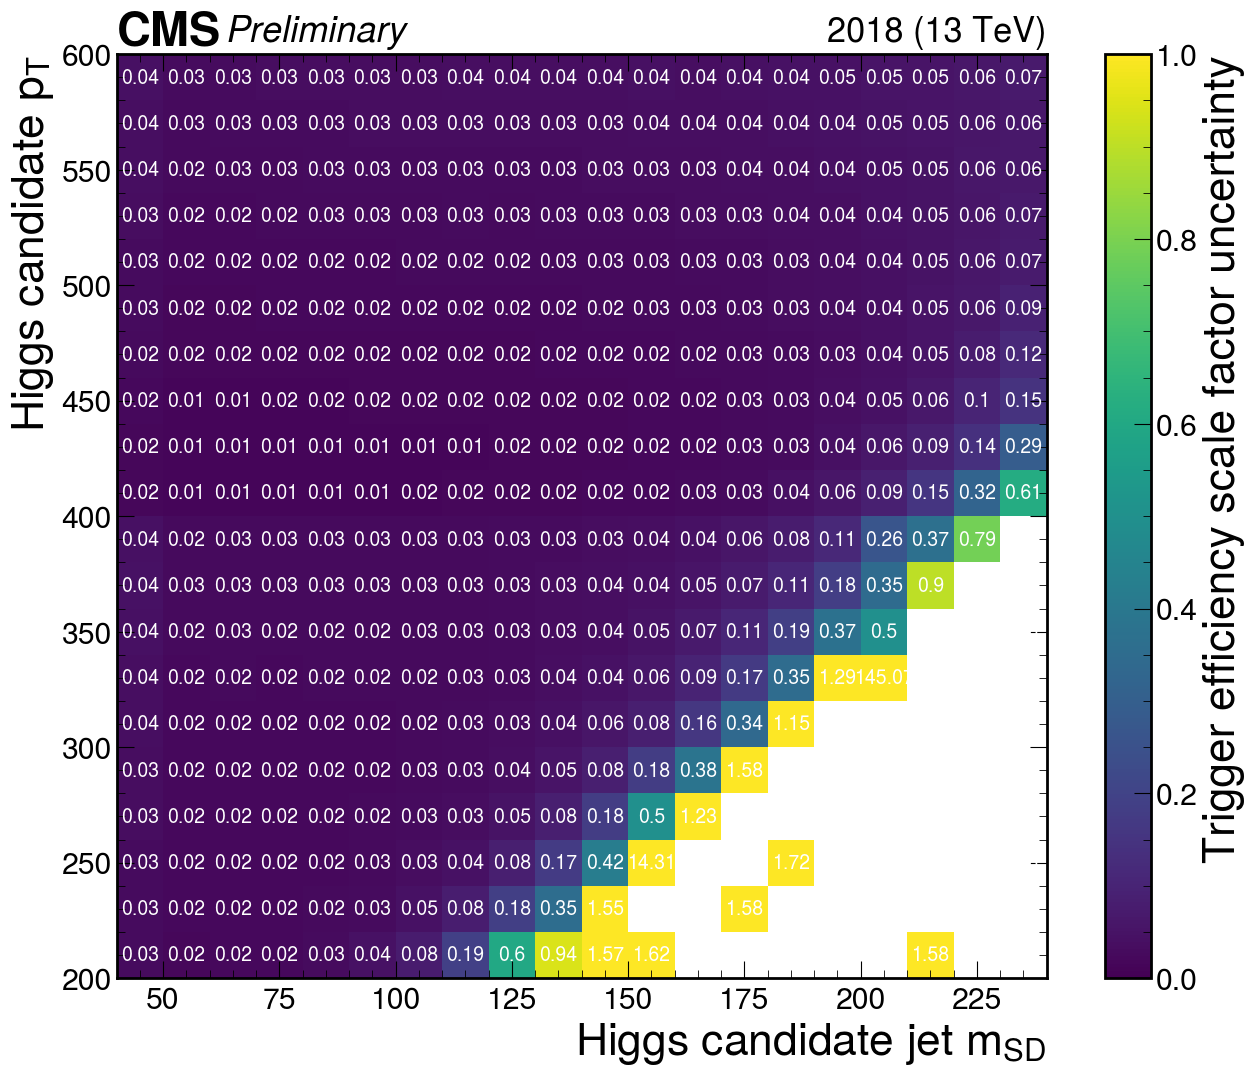

In [10]:
SF2DUnc_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",legend_location='lower right')

In [11]:
#Plot 2D trigger efficiency SFs.
def plot_effi_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2018", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet500"] == True)  | (eventsMC["HLT_PFHT1050"] == True)  | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True)  | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_PFHT1050"] == True)  | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True)  | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D

    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T,vmin = 0.8, vmax = 1.2 )
  
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Effi2DSF
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2018.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Higgs candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Higgs candidate $p_{T}$", fontsize=32, ha='right', y=1)
    # plt.savefig("./2DSFPlots/2018Max1p5" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')
    plt.savefig(f"{plot_dir}/2018WithValue" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_140271/1117748012.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_140271/1117748012.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value
/tmp/ipykernel_140271/1117748012.py:44: RuntimeWarning: divide by zero encountered in divide
  Effi2DSF = EffiData2D/EffiMC2D


When mass =  40.0  pT =  200.0 SF =  0.9385897308307207
When mass =  40.0  pT =  220.0 SF =  0.921375143118563
When mass =  40.0  pT =  240.0 SF =  0.9217172403882009
When mass =  40.0  pT =  260.0 SF =  0.9479827991064795
When mass =  40.0  pT =  280.0 SF =  0.9429096921170658
When mass =  40.0  pT =  300.0 SF =  1.0233115357647635
When mass =  40.0  pT =  320.0 SF =  1.0728794462842797
When mass =  40.0  pT =  340.0 SF =  1.208162452454965
When mass =  40.0  pT =  360.0 SF =  1.230445830614839
When mass =  40.0  pT =  380.0 SF =  1.1671699949628966
When mass =  40.0  pT =  400.0 SF =  0.7241242099844075
When mass =  40.0  pT =  420.0 SF =  0.7813064571698204
When mass =  40.0  pT =  440.0 SF =  0.8631101298446379
When mass =  40.0  pT =  460.0 SF =  0.9507676600495834
When mass =  40.0  pT =  480.0 SF =  0.9797217251272945
When mass =  40.0  pT =  500.0 SF =  0.9930698876083619
When mass =  40.0  pT =  520.0 SF =  0.9962055782534693
When mass =  40.0  pT =  540.0 SF =  0.997093679489

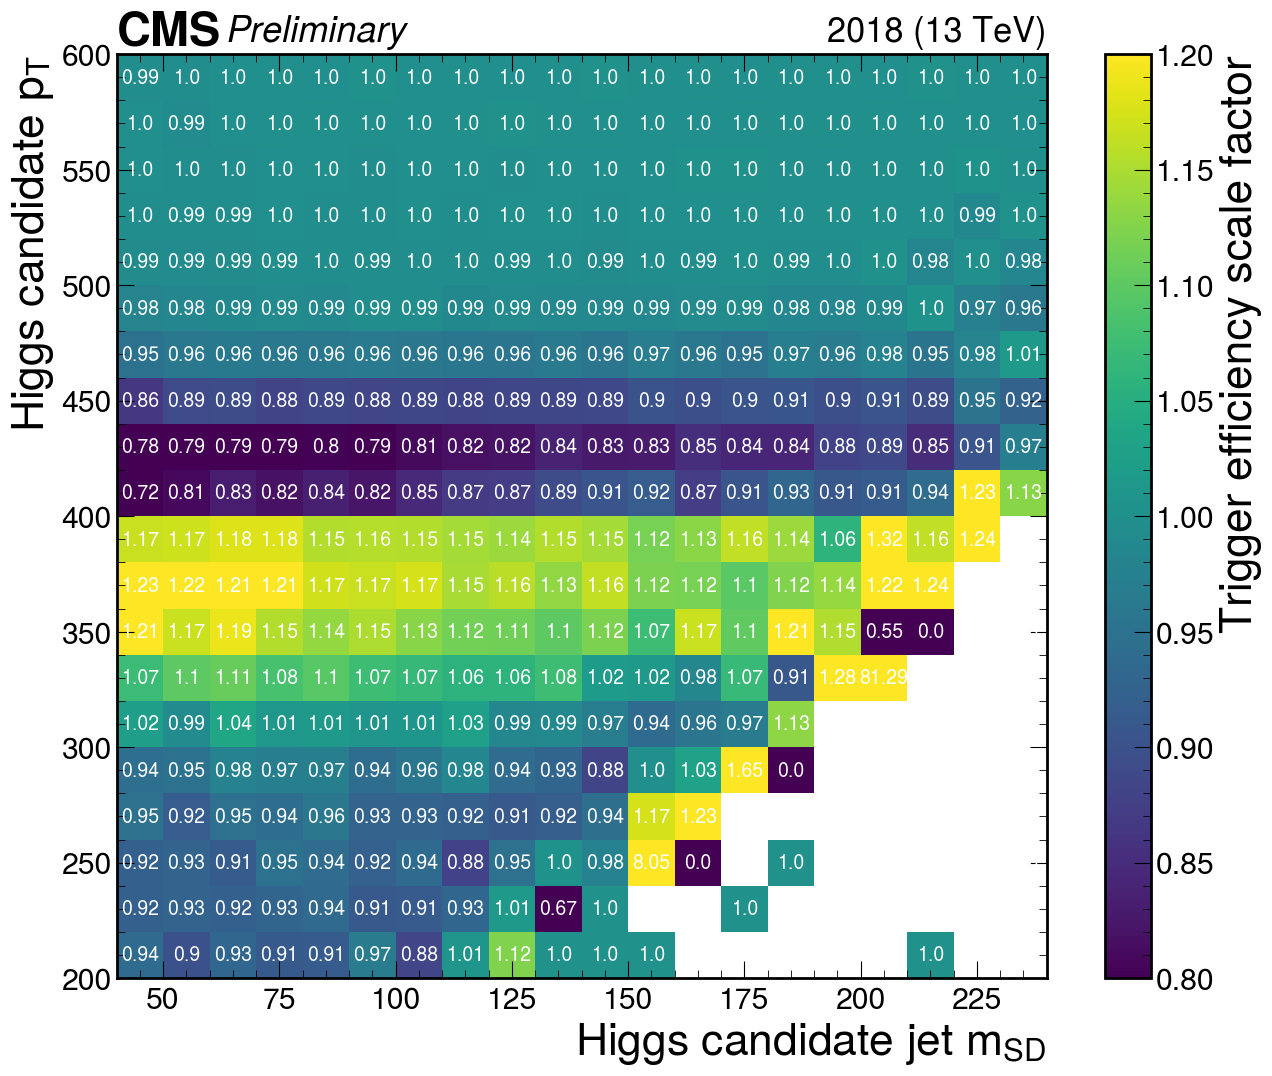

In [12]:
plot_effi_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",legend_location='lower right')

### (optional) plot the 2D trigger efficiency distributionm

In [13]:
#Plot 2D trigger efficiency SFs.
def TriggerEff2D(eventsMC, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2018", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20

    if isData:
        eventsData = eventsMC

        hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

        eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True)  | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_PFHT1050"] == True)  | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True)  | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]

        hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

        Effi2D = hist2DData_Cut.view().value / hist2DData.view().value
        mesh = ax.pcolormesh(*hist2DData.axes.edges.T, Effi2D.T )
        
        xedges = hist2DData.axes[0].edges
        print(xedges)
        yedges = hist2DData.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)

        Namesup = "SingleMuon:"
        namestr = "./2DSFPlots_Updated_07052023/2018DataEffi2D" + y_label + "_vs_" + x_label + ".pdf"

    else:
   
        hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])
    
        eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet500"] == True)  | (eventsMC["HLT_PFHT1050"] == True)  | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
        
        hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])
    
        Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value
        mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2D.T )
        
        xedges = hist2DMC.axes[0].edges
        print(xedges)
        yedges = hist2DMC.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
       
        Namesup = "QCD:"
        namestr = "./2DSFPlots_Updated_07052023/2018QCDEffi2D" + y_label + "_vs_" + x_label + ".pdf"





    # plt.title('2D-Trigger Efficiency', fontsize=32,color="black", x = 0.3, y = 0.9)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency', rotation= 90,fontsize=32)
    plt.xlabel(Namesup + r"Higgs candidate jet $m_{SD}$", fontsize=20, ha='right', x=1)
    plt.ylabel(Namesup + r"Higgs candidate $p_{T}$", fontsize=20, ha='right', y=1)
    plt.savefig(namestr, bbox_inches='tight')

    plt.show()

/tmp/ipykernel_52932/213321751.py:32: RuntimeWarning: invalid value encountered in divide
  Effi2D = hist2DData_Cut.view().value / hist2DData.view().value


[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]
[200. 220. 240. 260. 280. 300. 320. 340. 360. 380. 400. 420. 440. 460.
 480. 500. 520. 540. 560. 580. 600.]
[[0.68771215 0.68686869 0.68569164 0.67831612 0.6450253  0.65858844
  0.64485166 0.68330389 0.6984644  0.70704087 0.30530279 0.54411178
  0.78444236 0.92522573 0.97004019 0.98785086 0.99293286 0.9952858
  0.9965374  0.99419569]
 [0.56488336 0.58101616 0.57909397 0.56123536 0.55752079 0.56295203
  0.59894536 0.62441793 0.67446941 0.70473856 0.3400305  0.54086856
  0.79370272 0.92030057 0.96134531 0.9767141  0.9864203  0.99124487
  0.99033011 0.99568966]
 [0.61276332 0.59604019 0.57966051 0.58925426 0.58648971 0.59943011
  0.61235533 0.65330565 0.685317   0.71827083 0.3524063  0.54728499
  0.80534613 0.92885887 0.97149313 0.9833818  0.98994068 0.99307229
  0.99655963 0.99725777]
 [0.59939013 0.61042893 0.61754442 0.60216718 0.59542909 0.5960205
  0.61650851 0.64170616 0.69040

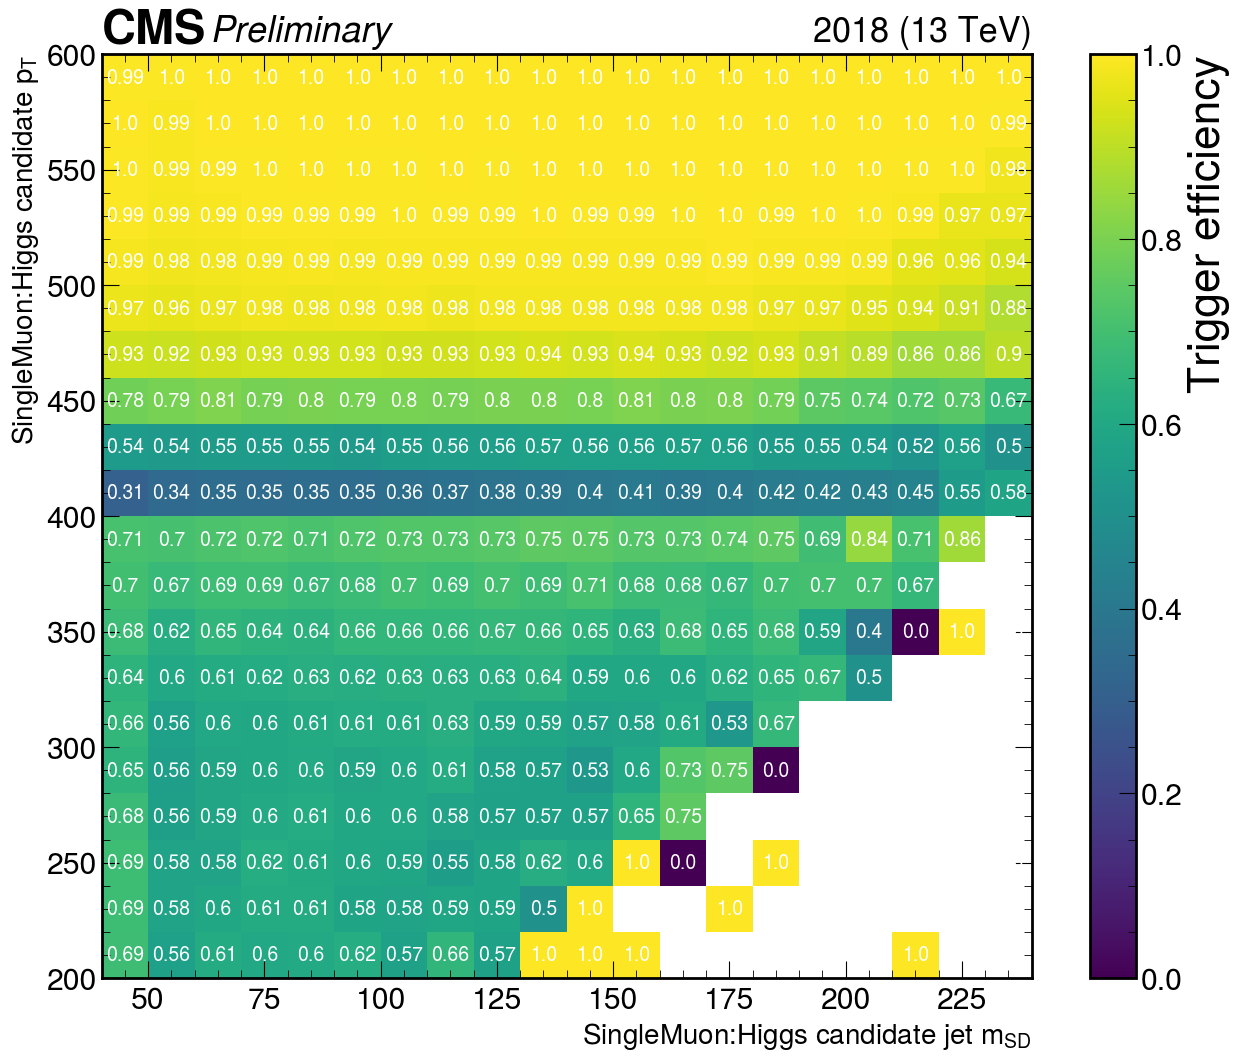

In [14]:
TriggerEff2D(eventsMC=events["SingleMuon"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')


/tmp/ipykernel_52932/3731531178.py:59: RuntimeWarning: invalid value encountered in divide
  Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value


[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]
[200. 220. 240. 260. 280. 300. 320. 340. 360. 380. 400. 420. 440. 460.
 480. 500. 520. 540. 560. 580. 600.]
[[0.73270794 0.74548211 0.74392841 0.71553632 0.68407961 0.64358547
  0.60104764 0.56557285 0.56765148 0.60577368 0.42161661 0.69641275
  0.90885547 0.97313547 0.99011808 0.99474455 0.99671482 0.99818685
  0.99932739 0.99981474]
 [0.62855928 0.62611535 0.62485491 0.61217088 0.58783042 0.56797186
  0.543838   0.53463084 0.55250096 0.60293231 0.42041239 0.68518956
  0.89273896 0.95787043 0.97720402 0.98543653 0.99211596 0.99607527
  0.99836122 0.99910144]
 [0.65816889 0.64707343 0.6336302  0.62135827 0.599913   0.57812146
  0.55300893 0.5500334  0.56474562 0.60939145 0.42382712 0.69010113
  0.90112716 0.96601349 0.98389055 0.99051184 0.9950105  0.99740697
  0.99867446 0.99953674]
 [0.65755884 0.65723413 0.65012994 0.6391971  0.6142717  0.58830894
  0.56895849 0.55632534 0.571

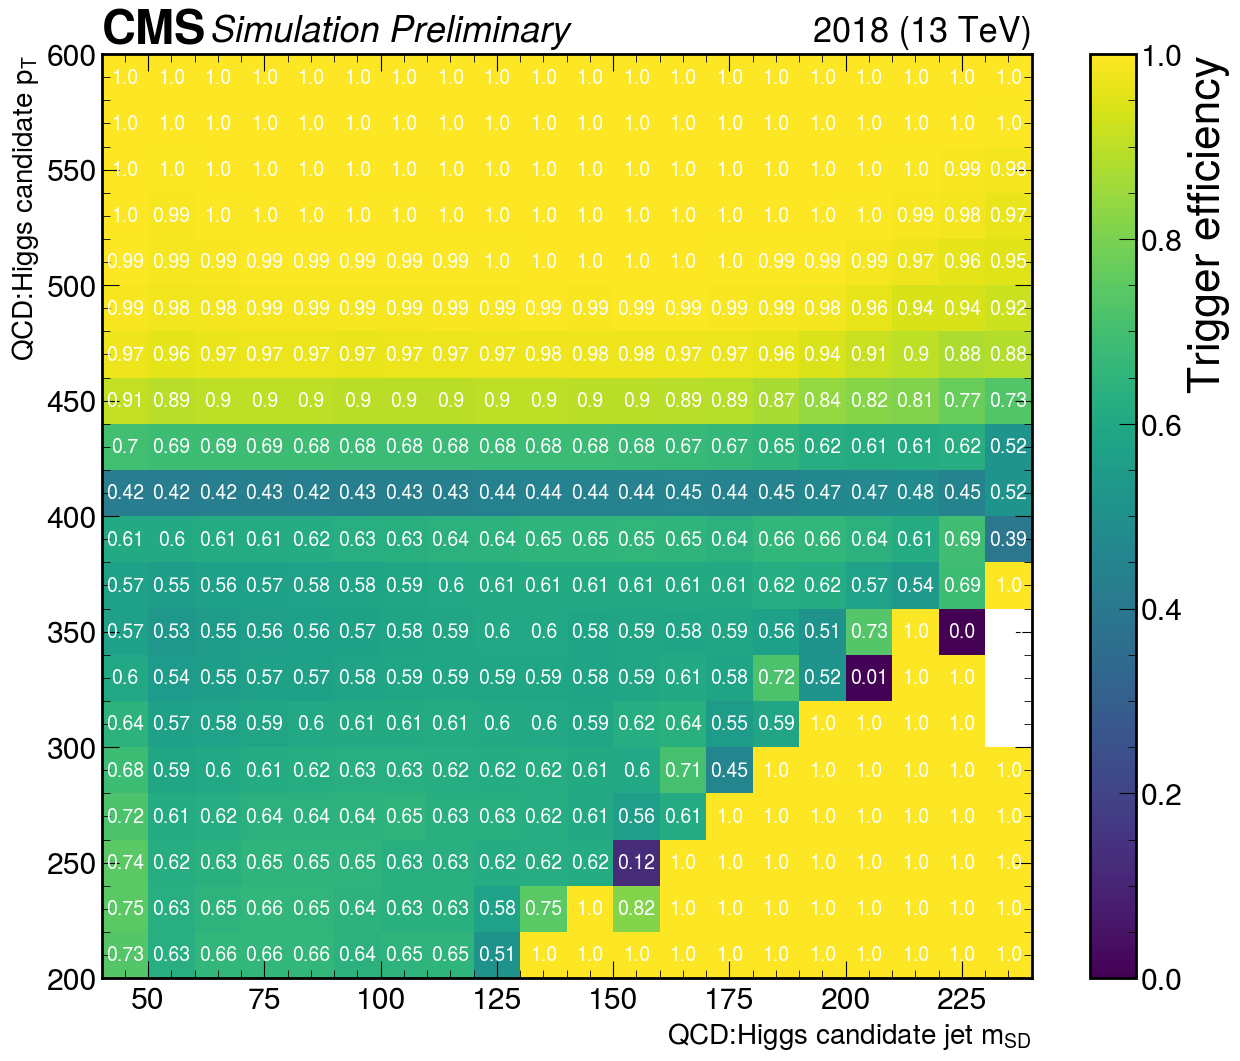

/tmp/ipykernel_52932/3731531178.py:32: RuntimeWarning: invalid value encountered in divide
  Effi2D = hist2DData_Cut.view().value / hist2DData.view().value


[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]
[200. 220. 240. 260. 280. 300. 320. 340. 360. 380. 400. 420. 440. 460.
 480. 500. 520. 540. 560. 580. 600.]
[[0.68883774 0.70734727 0.71973725 0.70751144 0.68090397 0.64792322
  0.6080251  0.55547909 0.52505122 0.53382228 0.3209517  0.54904133
  0.8089448  0.94032055 0.98090843 0.9924988  0.99602553 0.99725636
  0.99820345 0.99870628]
 [0.59302583 0.59417663 0.59188874 0.58099172 0.56092277 0.53602034
  0.51061821 0.48618674 0.48285045 0.51146098 0.32322692 0.54770198
  0.80834649 0.93740725 0.97785898 0.98809321 0.99228366 0.99539183
  0.99714973 0.99850975]
 [0.59150052 0.58851868 0.58851973 0.57974615 0.55979658 0.53819239
  0.51295323 0.49194932 0.48614106 0.51459777 0.32978073 0.55113523
  0.81098416 0.94149753 0.98086146 0.9912739  0.99479849 0.99680117
  0.99837813 0.99879929]
 [0.58446491 0.58307874 0.58458007 0.57867493 0.56270379 0.54089406
  0.51581151 0.4945363  0.491

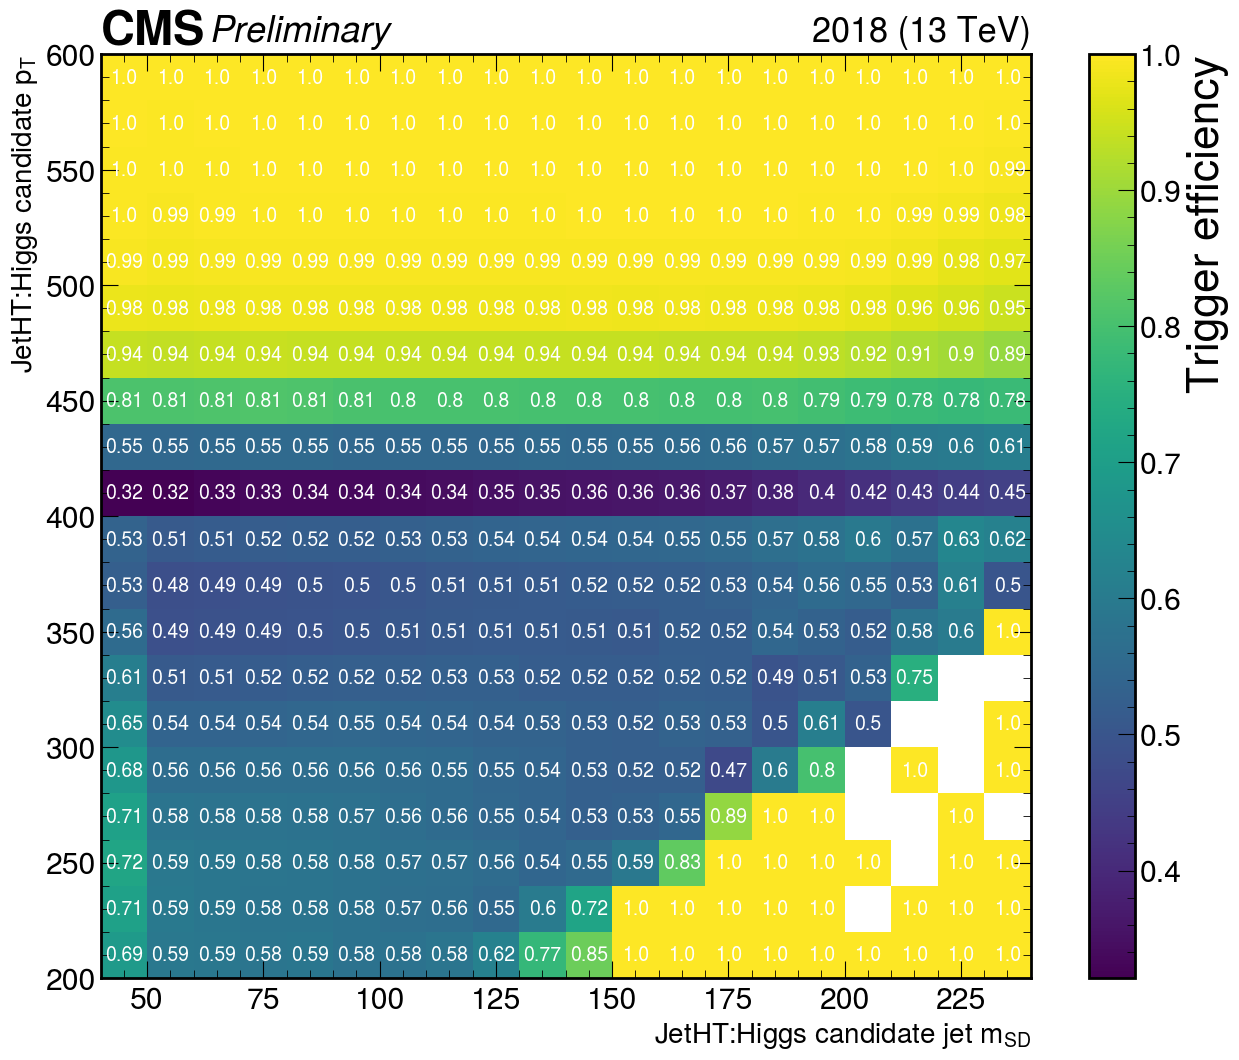

In [11]:
TriggerEff2D(eventsMC=events["QCD"],isData = False,  x_label="Mja", y_label = "PTja",legend_location='lower right')
# TriggerEff2D(eventsMC=events["JetHT"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')
